In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import PIL
import itertools
import numpy as np
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

2023-11-03 14:36:13.851817: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-03 14:36:13.853094: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-03 14:36:13.878936: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-03 14:36:13.879550: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-03 14:36:14.374998: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
#os.chdir('/home/hduser/Desktop/testing2/')

In [3]:
import pathlib
data_dir = pathlib.Path('/home/hduser/Desktop/processed data/')

In [4]:
print(data_dir)

/home/hduser/Desktop/processed data


/home/hduser/Desktop/processed data/barbutellus/barbutellus_gray_12.jpg


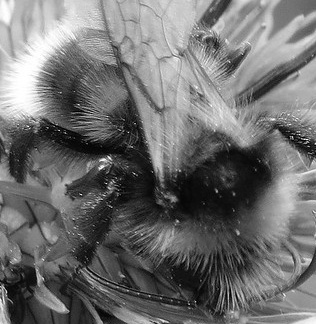

In [5]:
barbutellus = list(data_dir.glob('barbutellus/*'))
print(barbutellus[10])
PIL.Image.open(str(barbutellus[10]))

In [6]:
img_height, img_width = (224, 224)
batch_size = 32

In [7]:
train_batches = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split=0.2,
    subset='training', seed=8,
    #labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width), 
    batch_size=batch_size)

Found 1260 files belonging to 21 classes.
Using 1008 files for training.


In [8]:
file_count = 0

for root, dirs, files in os.walk(data_dir):
    file_count += len(files)

print("Total number of files in the directory and its subdirectories:", file_count)

Total number of files in the directory and its subdirectories: 1260


In [9]:
validate_batches = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split=0.2,
    subset='validation', seed=8,
    label_mode='categorical',
    image_size=(img_height, img_width), 
    batch_size=batch_size)

Found 1260 files belonging to 21 classes.
Using 252 files for validation.


In [10]:
class_names = train_batches.class_names
print(class_names)

['barbutellus', 'bohemicus', 'campestris', 'cryptarum', 'distinguendus', 'hortorum', 'hypnorum', 'jonellus', 'lapidarius', 'lucorum', 'magnus', 'monticola', 'muscorum', 'pascuorum', 'pratorum', 'ruderarius', 'rupestris', 'sylvarum', 'sylvestris', 'terrestris', 'vestalis']


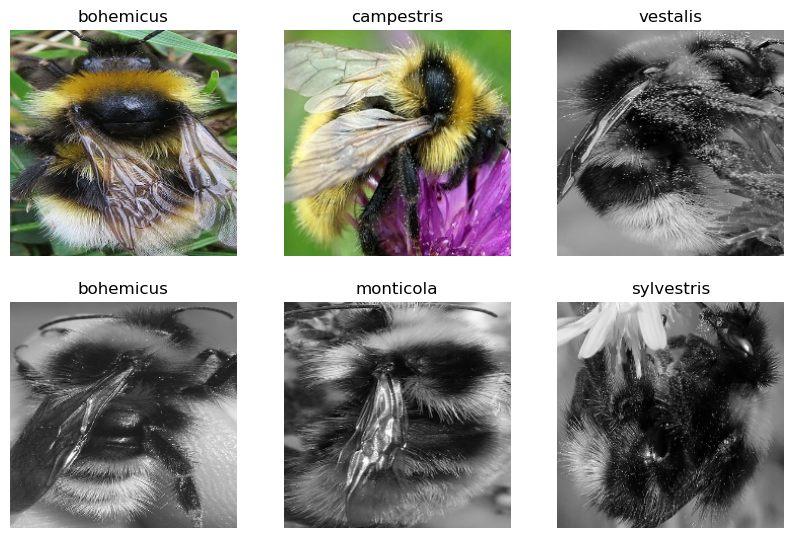

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_batches.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = labels[i].numpy().argmax()
        plt.title(class_names[label_index])
        plt.axis("off")

## 1. ResNet50

In [12]:
resnet50 = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',classes=21,
    weights='imagenet')

for layer in resnet50.layers:
        layer.trainable=False

In [13]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [14]:
model_resnet50 = Sequential()

model_resnet50.add(resnet50)
model_resnet50.add(Flatten())
model_resnet50.add(Dense(512, activation='relu'))
model_resnet50.add(Dense(256, activation='relu'))
model_resnet50.add(Dense(128, activation='relu'))
#model_resnet50.add(Dense(64, activation='relu'))
#model_resnet50.add(Dense(32, activation='relu'))
model_resnet50.add(Dense(21, activation='softmax'))

In [15]:
model_resnet50.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 21)                2709      
                                                                 
Total params: 24803733 (94.62 MB)
Trainable params: 1216

In [16]:
model_resnet50.compile(optimizer=Adam(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

In [17]:
epoch_resnet50 = 20

result_resnet50 = model_resnet50.fit(train_batches,
                                     validation_data=validate_batches,
                                     epochs=epoch_resnet50,
                                     verbose=2)

Epoch 1/20
32/32 - 23s - loss: 3.0761 - accuracy: 0.0804 - val_loss: 2.8824 - val_accuracy: 0.1508 - 23s/epoch - 722ms/step
Epoch 2/20
32/32 - 21s - loss: 2.5585 - accuracy: 0.2202 - val_loss: 2.5282 - val_accuracy: 0.2262 - 21s/epoch - 649ms/step
Epoch 3/20
32/32 - 21s - loss: 2.0239 - accuracy: 0.3631 - val_loss: 2.3037 - val_accuracy: 0.2817 - 21s/epoch - 650ms/step
Epoch 4/20
32/32 - 21s - loss: 1.5915 - accuracy: 0.5198 - val_loss: 2.1357 - val_accuracy: 0.3333 - 21s/epoch - 647ms/step
Epoch 5/20
32/32 - 21s - loss: 1.2979 - accuracy: 0.5744 - val_loss: 2.0046 - val_accuracy: 0.3611 - 21s/epoch - 647ms/step
Epoch 6/20
32/32 - 21s - loss: 0.8539 - accuracy: 0.7490 - val_loss: 2.0319 - val_accuracy: 0.4048 - 21s/epoch - 650ms/step
Epoch 7/20
32/32 - 21s - loss: 0.6546 - accuracy: 0.8046 - val_loss: 1.6479 - val_accuracy: 0.5000 - 21s/epoch - 646ms/step
Epoch 8/20
32/32 - 21s - loss: 0.3619 - accuracy: 0.9117 - val_loss: 1.6096 - val_accuracy: 0.4643 - 21s/epoch - 650ms/step
Epoch 9/

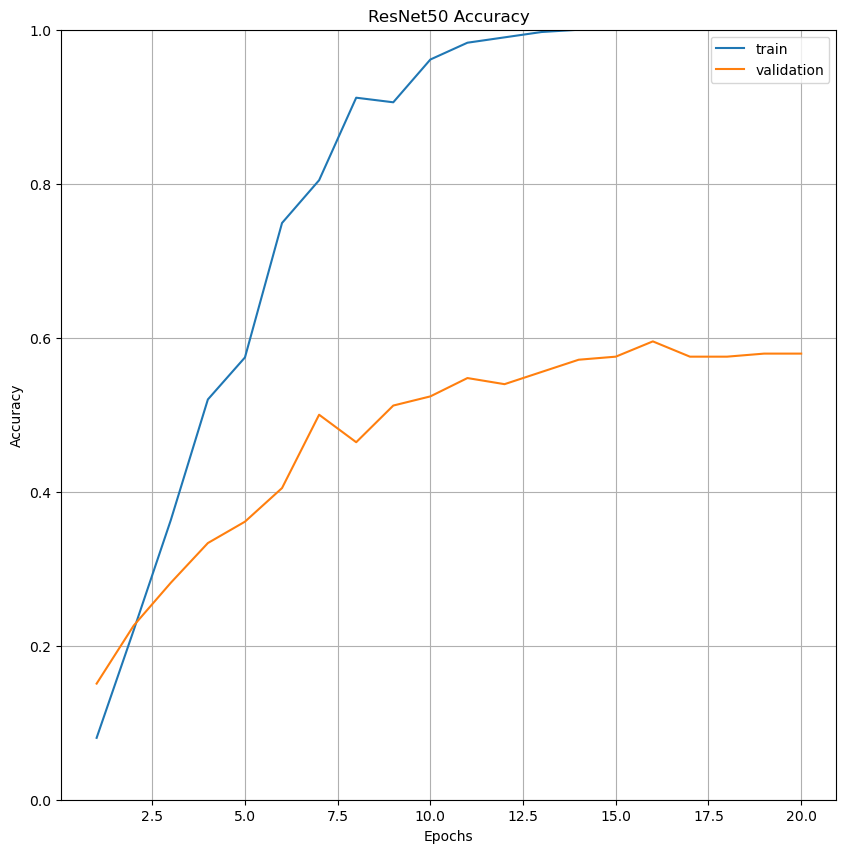

In [18]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_resnet50 + 1)
plt.plot(epochs_range, result_resnet50.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, result_resnet50.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('ResNet50 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

## 2. VGG19

In [ ]:
vgg19 = tf.keras.applications.VGG19(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',classes=21,
    weights='imagenet')

for layer in vgg19.layers:
        layer.trainable=False

In [ ]:
vgg19.summary()

In [ ]:
model_vgg19 = Sequential()

model_vgg19.add(vgg19)
model_vgg19.add(Flatten())
model_vgg19.add(Dense(512, activation='relu'))
model_vgg19.add(Dense(256, activation='relu'))
model_vgg19.add(Dense(128, activation='relu'))
#model_vgg19.add(Dense(64, activation='relu'))
#model_vgg19.add(Dense(32, activation='relu'))
model_vgg19.add(Dense(21, activation='softmax'))

In [ ]:
model_vgg19.summary()

In [ ]:
model_vgg19.compile(optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
epoch_vgg19 = 10

result_vgg19 = model_vgg19.fit(train_batches,
                               validation_data=validate_batches,
                               epochs=epoch_vgg19,
                               verbose=2)

In [ ]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_vgg19 + 1)
plt.plot(epochs_range, result_vgg19.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, result_vgg19.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('VGG19 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

## 3. InceptionV3

In [ ]:
inceptionv3 = tf.keras.applications.VGG19(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',classes=21,
    weights='imagenet')

for layer in inceptionv3.layers:
        layer.trainable=False

In [ ]:
inceptionv3.summary()

In [ ]:
model_inceptionv3 = Sequential()

model_inceptionv3.add(inceptionv3)
model_inceptionv3.add(Flatten())
model_inceptionv3.add(Dense(512, activation='relu'))
model_inceptionv3.add(Dense(256, activation='relu'))
model_inceptionv3.add(Dense(128, activation='relu'))
#model_resnet50.add(Dense(64, activation='relu'))
#model_resnet50.add(Dense(32, activation='relu'))
model_inceptionv3.add(Dense(21, activation='softmax'))

In [ ]:
model_inceptionv3.summary()    

In [ ]:
model_inceptionv3.compile(optimizer=Adam(learning_rate=0.001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

In [ ]:
epoch_inceptionv3 = 10

result_inceptionv3 = model_inceptionv3.fit(train_batches,
                                           validation_data=validate_batches,
                                           epochs=epoch_inceptionv3,
                                           verbose=2)

In [ ]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_inceptionv3 + 1)
plt.plot(epochs_range, result_inceptionv3.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, result_inceptionv3.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('InceptionV3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

## 4. MobileNetV2

In [ ]:
mobilenetv2 = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg',classes=21,
    weights='imagenet')

for layer in mobilenetv2.layers:
        layer.trainable=False

In [ ]:
mobilenetv2.summary()

In [ ]:
model_mobilenetv2 = Sequential()

model_mobilenetv2.add(mobilenetv2)
model_mobilenetv2.add(Flatten())
model_mobilenetv2.add(Dense(512, activation='relu'))
model_mobilenetv2.add(Dense(256, activation='relu'))
model_mobilenetv2.add(Dense(128, activation='relu'))
#model_mobilenetv2.add(Dense(64, activation='relu'))
#model_mobilenetv2.add(Dense(32, activation='relu'))
model_mobilenetv2.add(Dense(21, activation='softmax'))

In [ ]:
model_mobilenetv2.summary()

In [ ]:
model_mobilenetv2.compile(optimizer=Adam(learning_rate=0.001),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

In [ ]:
epoch_mobilenetv2 = 30

result_mobilenetv2 = model_mobilenetv2.fit(train_batches,
                                           validation_data=validate_batches,
                                           epochs=epoch_mobilenetv2,
                                           verbose=2)

In [ ]:
plt.figure(figsize=(10, 10))
epochs_range = range(1, epoch_mobilenetv2 + 1)
plt.plot(epochs_range, result_mobilenetv2.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, result_mobilenetv2.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('MoblieNetV2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()